In [24]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [46]:
'''
    GT_JSON: valid set json file path
    현재 예시에서는 train.json을 임의로 valid set으로 사용
    PRED_CSV: 위의 valid set을 inference한 submission file
'''
GT_JSON = '../dataset/kfold/seed41/val_4.json'
#PRED_CSV = 'work_dirs/inseo_test/yolox_x(scaling+soft nms)/val_best_bbox_mAP_50_epoch_42.csv'
PRED_CSV = 'calibration_submission_best_bbox_mAP_50_epoch_42.csv'
#PRED_CSV = 'val_calibration.csv'

LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
    
    
# load ground truth
with open(GT_JSON, 'r') as outfile:
    test_anno = (json.load(outfile))

# load prediction
pred_df = pd.read_csv(PRED_CSV)   

In [47]:
'''
[
    [file_name label_index confidence_score x_min x_max y_min y_max], 
    [file_name label_index confidence_score x_min x_max y_min y_max],
    ,,,
    [file_name label_index confidence_score x_min x_max y_min y_max]
]

이는 아래의 mean_average_precision_for_boxes 함수에 들어갈 양식입니다.
new_pred가 위와 같은 format을 갖도록, submission.csv를 가공해봅시다.
'''
    
new_pred = []

file_names = pred_df['image_id'].values.tolist()
bboxes = pred_df['PredictionString'].values.tolist()
    
'''
create new_pred
'''
    
for i, bbox in enumerate(bboxes):
    if isinstance(bbox, float):
        print(f'{file_names[i]} empty box')

for file_name, bbox in tqdm(zip(file_names, bboxes)):
    boxes = np.array(str(bbox).split(' '))
    if len(boxes) % 6 == 1:
        boxes = boxes[:-1].reshape(-1, 6)
    else:
        raise Exception('error', 'invalid box count')
    for box in boxes:
        new_pred.append([file_name, box[0], box[1], float(box[2]), float(box[4]), float(box[3]), float(box[5])])

4871it [00:01, 3362.11it/s]


In [38]:
'''
[
    [file_name 1, confidence_score, x_min, x_max, y_min, y_max], 
    [file_name 2, confidence_score, x_min, x_max, y_min, y_max],
    ,,,
    [file_name , confidence_score, x_min, x_max, y_min, y_max]
]

아래의 mean_average_precision_for_boxes 함수에 들어갈 양식, gt 양식
'''
    
gt = []


'''
coco.getImgIds(): return image id list
    
coco.loadImgs(image_id): return image_info
    
image_info['file_name']: return file name
   
coco.getAnnIds(imgIds=image_info['id']): return annotation id
    
coco.loadAnns(ann_ids): return annotation information list (annotation_info_list)
    
annotation_info_list[i]['bbox']: return i'th annotation [x_min, y_min, w, h]
    
annotation_info_list[i]['category_id']: return i'th annotation category
    
'''
    
coco = COCO(GT_JSON)

'''
create gt
: image id 별로 GT 값 추가
'''
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
        
    file_name = image_info['file_name']
        
    for annotation in annotation_info_list:
        gt.append([file_name, annotation['category_id'],
                   float(annotation['bbox'][0]),
                   float(annotation['bbox'][0]) + float(annotation['bbox'][2]),
                   float(annotation['bbox'][1]),
                   (float(annotation['bbox'][1]) + float(annotation['bbox'][3]))])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# function

In [39]:
'''
    compute_overlap: GT와 prediction이 얼마나 겹치는지, 즉 IOU를 계산하는 함수
    mAP50에서 compute_overlap결과가 50이상이면 true prediction으로 판별, 
        50미만이면 false prediction으로 판별
'''
def compute_overlap(boxes, query_boxes):
    """
    Args:
        a: (N, 4) ndarray of float
        b: (K, 4) ndarray of float
    Returns:
        overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    overlaps = np.zeros((N, K), dtype=np.float64)
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0]) *
            (query_boxes[k, 3] - query_boxes[k, 1])
        )
        for n in range(N):
            iw = (
                min(boxes[n, 2], query_boxes[k, 2]) -
                max(boxes[n, 0], query_boxes[k, 0])
            )
            if iw > 0:
                ih = (
                    min(boxes[n, 3], query_boxes[k, 3]) -
                    max(boxes[n, 1], query_boxes[k, 1])
                )
                if ih > 0:
                    ua = np.float64(
                        (boxes[n, 2] - boxes[n, 0]) *
                        (boxes[n, 3] - boxes[n, 1]) +
                        box_area - iw * ih
                    )
                    overlaps[n, k] = iw * ih / ua
    return overlaps

In [40]:
'''
    get_real_annotations: GT box format을 계산하기 쉬운 box format으로 바꿔주는 함수
'''
def get_real_annotations(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i]]
        res[id][label].append(box)

    return res


In [41]:
'''
    get_detections: get_real_annotations 함수와 비슷하게 prediction의 box format을 바꿔주는 함수
    get_real_annotations과의 차이점은 각 score별로 prediction, recall을 계산하기 위하여 score를 포함
'''
def get_detections(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    scores = table['Conf'].values.astype(np.float32)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i], scores[i]]
        res[id][label].append(box)

    return res

In [42]:
'''
    _compute_ap: 계산된 recall과 precision에 따라서 AP를 계산해주는 함수.
'''
def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [43]:
'''
    mean_average_precision_for_boxes: GT와 prediction을 넣으면 iou_threshold에 따라서 mAP를 계산해주는 함수.
    해당 대회에서는 mAP50을 사용하여 iou_threshold의 default값을 0.5로 설정
'''
def mean_average_precision_for_boxes(ann, pred, iou_threshold=0.5):
    """
    :param ann: path to CSV-file with annotations or numpy array of shape (N, 6)
    :param pred: path to CSV-file with predictions (detections) or numpy array of shape (N, 7)
    :param iou_threshold: IoU between boxes which count as 'match'. Default: 0.5
    :return: tuple, where first value is mAP and second values is dict with AP for each class.
    """
    global ap_dict
    if isinstance(ann, str):
        valid = pd.read_csv(ann)
    else:
        valid = pd.DataFrame(ann, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])

    if isinstance(pred, str):
        preds = pd.read_csv(pred)
    else:
        preds = pd.DataFrame(pred, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])

    ann_unique = valid['ImageID'].unique()
    preds_unique = preds['ImageID'].unique()

    print('Number of files in annotations: {}'.format(len(ann_unique)))
    print('Number of files in predictions: {}'.format(len(preds_unique)))


    unique_classes = valid['LabelName'].unique().astype(np.str)
    
    print('Unique classes: {}'.format(len(unique_classes)))

    all_detections = get_detections(preds)
    all_annotations = get_real_annotations(valid)
    
    print('Detections length: {}'.format(len(all_detections)))
    print('Annotations length: {}'.format(len(all_annotations)))

    average_precisions = {}
    for _, label in enumerate(sorted(unique_classes)):

        # Negative class
        if str(label) == 'nan':
            continue

        false_positives = []
        true_positives = []
        scores = []
        num_annotations = 0.0

        for i in range(len(ann_unique)):
            detections = []
            annotations = []
            id = ann_unique[i]
            if id in all_detections:
                if label in all_detections[id]:
                    detections = all_detections[id][label]
            if id in all_annotations:
                if label in all_annotations[id]:
                    annotations = all_annotations[id][label]

            if len(detections) == 0 and len(annotations) == 0:
                continue

            num_annotations += len(annotations)
            detected_annotations = []

            annotations = np.array(annotations, dtype=np.float64)
            for d in detections:
                scores.append(d[4])

                if len(annotations) == 0:
                    false_positives.append(1)
                    true_positives.append(0)
                    continue

                overlaps = compute_overlap(np.expand_dims(np.array(d, dtype=np.float64), axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives.append(0)
                    true_positives.append(1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives.append(1)
                    true_positives.append(0)

        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        false_positives = np.array(false_positives)
        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
        # 각 label 별로 PR curve plot
        plt.plot(recall, precision)
        plt.title(f'{LABEL_NAME[int(label)]} PR curve', fontsize=20)
        plt.xlabel('Recall', fontsize=18)
        plt.ylabel('Precision', fontsize=18)
        plt.show()

        # compute average precision
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations
        s1 = "{:10s} | {:.6f} | {:7d}".format(LABEL_NAME[int(label)], average_precision, int(num_annotations))
        ap_dict[LABEL_NAME[int(label)]] = average_precision
        print(s1)

    present_classes = 0
    precision = 0
    for label, (average_precision, num_annotations) in average_precisions.items():
        if num_annotations > 0:
            present_classes += 1
            precision += average_precision
            
    mean_ap = precision / present_classes
    print('mAP: {:.6f}'.format(mean_ap))
    
    return mean_ap, average_precisions

# output

Number of files in annotations: 974
Number of files in predictions: 974
Unique classes: 10


/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

Detections length: 974
Annotations length: 974


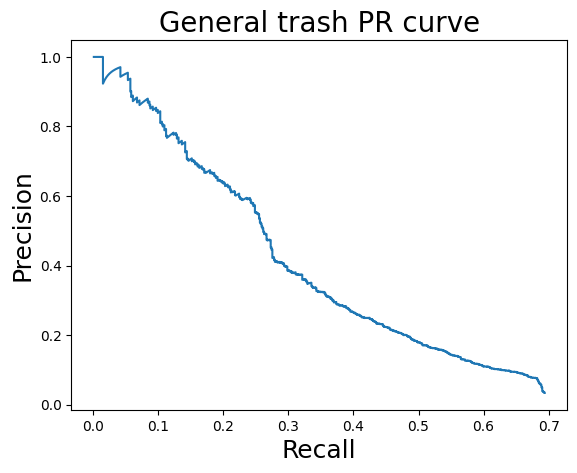

General trash | 0.296306 |     784


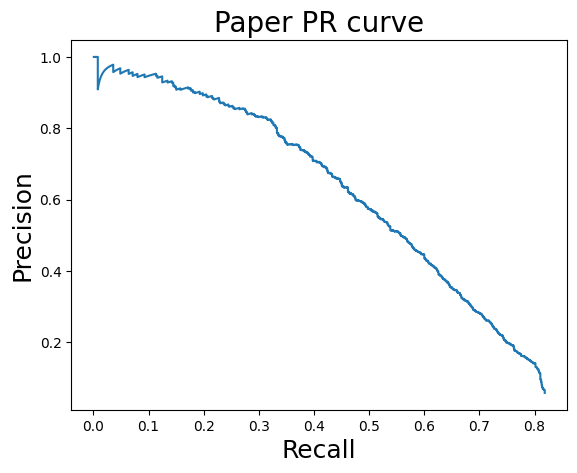

Paper      | 0.526809 |    1250


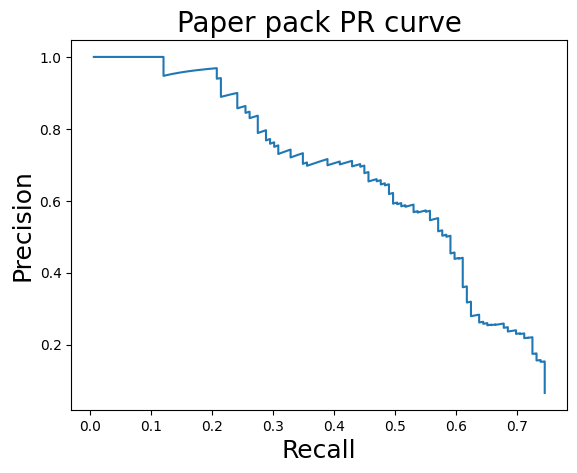

Paper pack | 0.517312 |     149


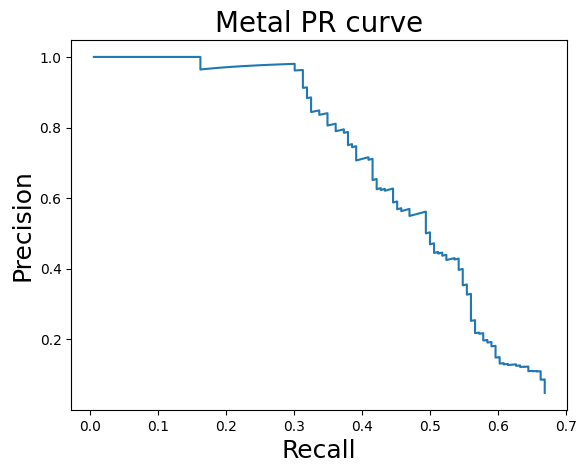

Metal      | 0.482636 |     166


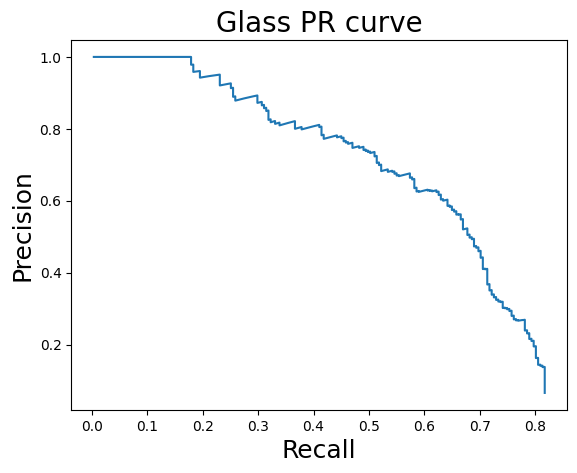

Glass      | 0.608501 |     251


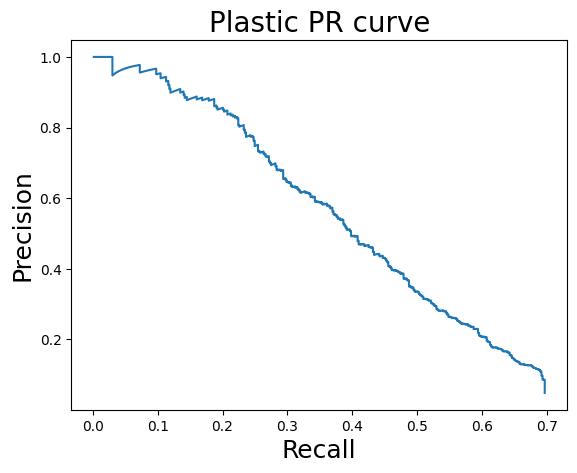

Plastic    | 0.405766 |     593


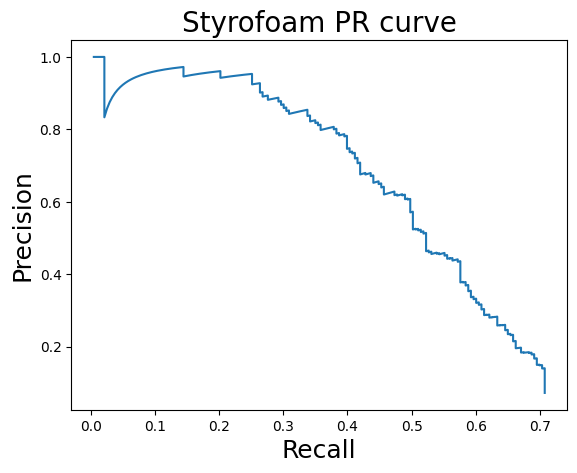

Styrofoam  | 0.504959 |     243


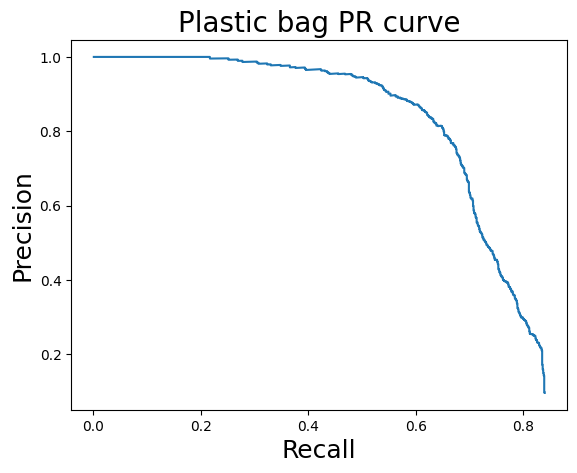

Plastic bag | 0.717080 |    1042


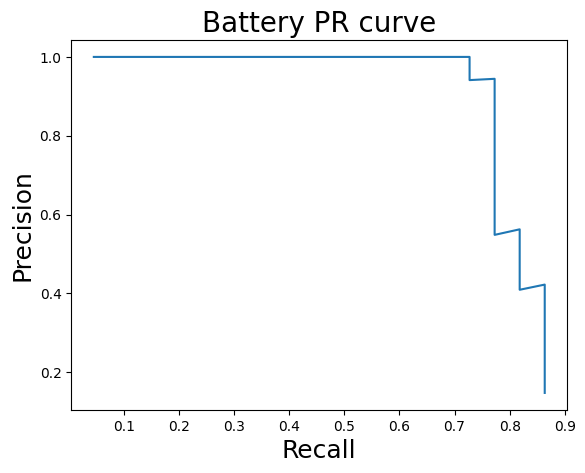

Battery    | 0.814962 |      22


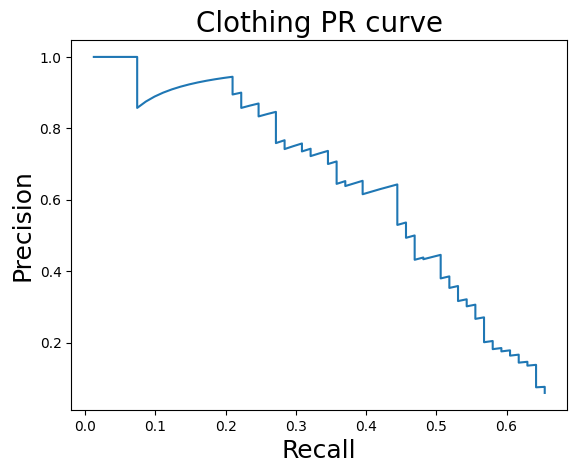

Clothing   | 0.439064 |      81
mAP: 0.531340
0.5313395558961008
{'General trash': 0.2963064163029699, 'Plastic': 0.40576646437817043, 'Clothing': 0.43906449922583934, 'Metal': 0.48263559703040304, 'Styrofoam': 0.5049588280157844, 'Paper pack': 0.5173115461830362, 'Paper': 0.5268090658598066, 'Glass': 0.6085009720443746, 'Plastic bag': 0.717080048708502, 'Battery': 0.8149621212121213}


In [44]:
'''
calculate mAP
'''
ap_dict = {}
mean_ap, average_precisions = mean_average_precision_for_boxes(gt, new_pred, iou_threshold=0.5)

print(mean_ap)
print({k: v for k, v in sorted(ap_dict.items(), key=lambda item: item[1])})

Number of files in annotations: 974
Number of files in predictions: 974
Unique classes: 10


/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

Detections length: 974
Annotations length: 974


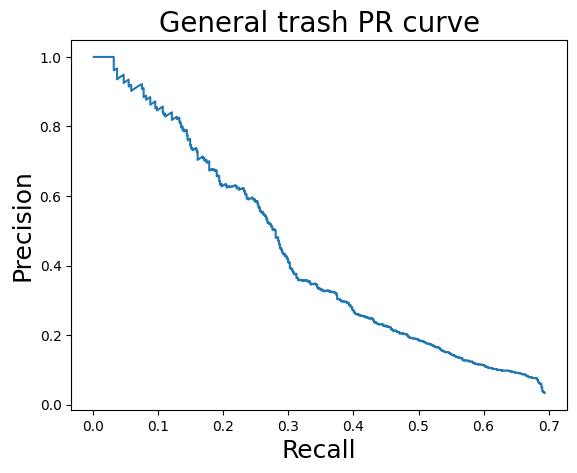

General trash | 0.305251 |     784


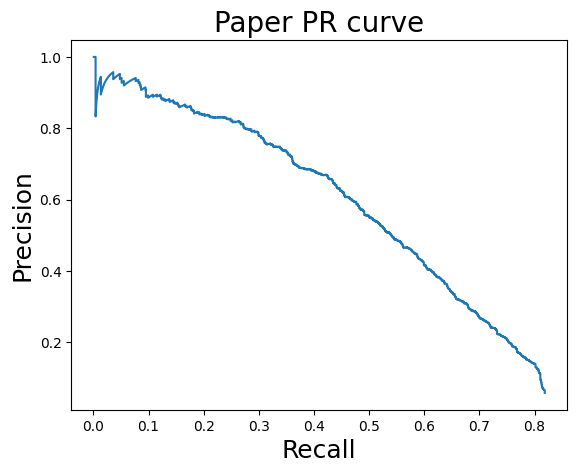

Paper      | 0.504252 |    1250


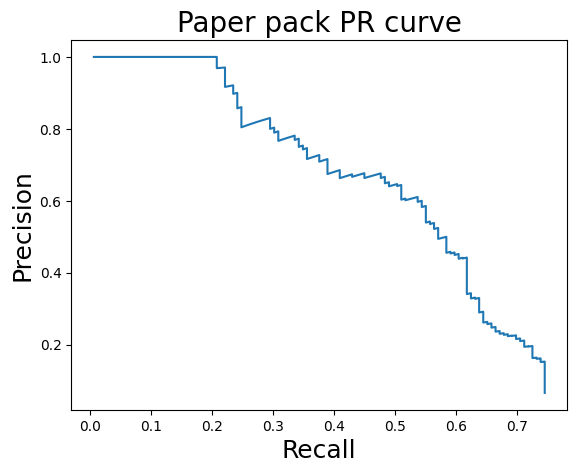

Paper pack | 0.523806 |     149


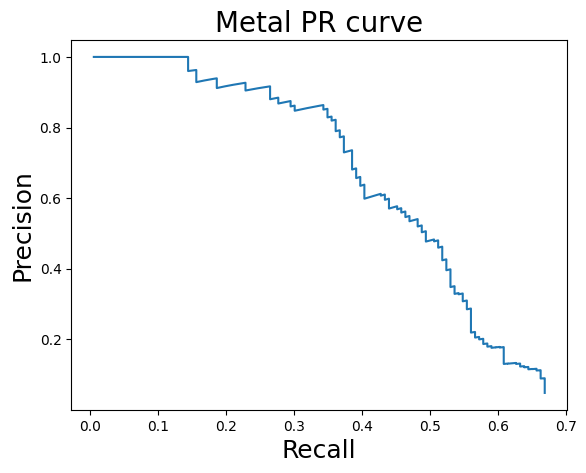

Metal      | 0.464607 |     166


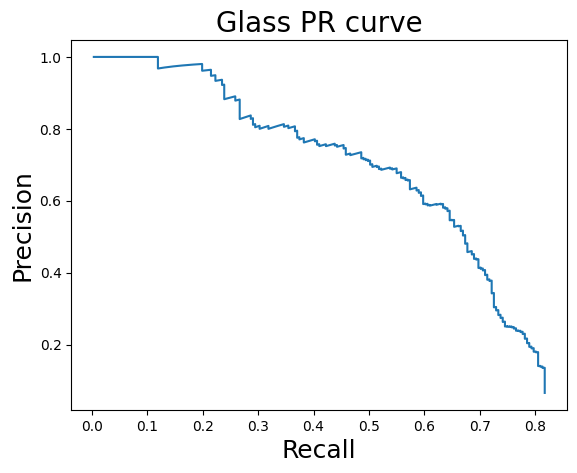

Glass      | 0.593039 |     251


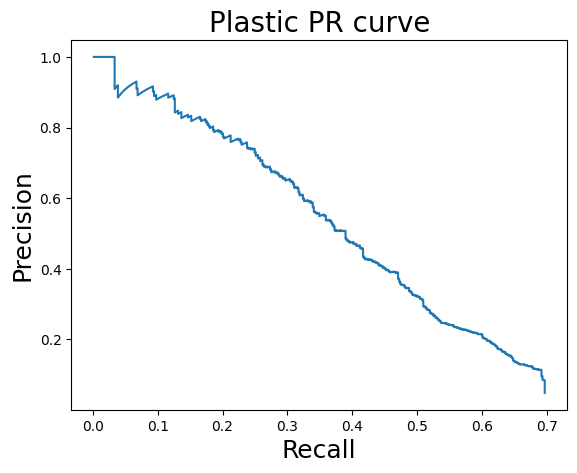

Plastic    | 0.386695 |     593


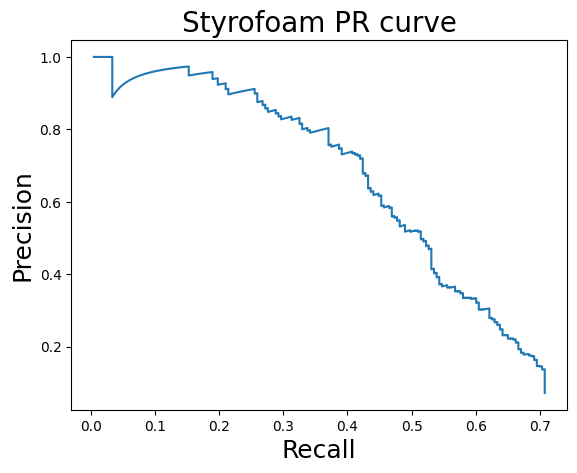

Styrofoam  | 0.490634 |     243


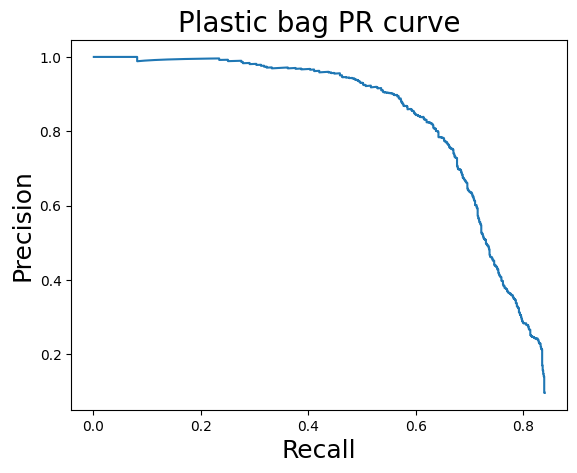

Plastic bag | 0.711938 |    1042


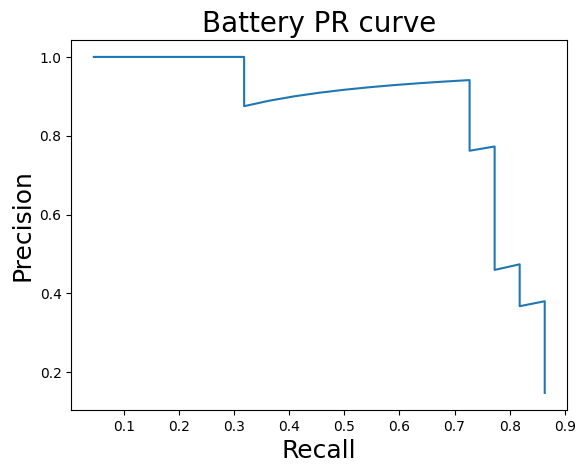

Battery    | 0.777136 |      22


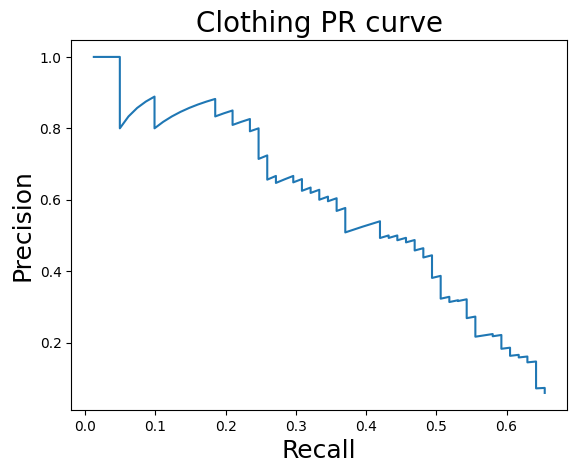

Clothing   | 0.399959 |      81
mAP: 0.515732
0.5157317447474646
{'General trash': 0.3052513913499455, 'Plastic': 0.38669548363541106, 'Clothing': 0.39995912990063914, 'Metal': 0.4646067486348876, 'Styrofoam': 0.49063406090081585, 'Paper': 0.5042518237743967, 'Paper pack': 0.5238056013073562, 'Glass': 0.5930390772571081, 'Plastic bag': 0.7119377798710079, 'Battery': 0.7771363508430775}


In [40]:
'''
calculate mAP
'''
ap_dict = {}
mean_ap, average_precisions = mean_average_precision_for_boxes(gt, new_pred, iou_threshold=0.5)

print(mean_ap)
print({k: v for k, v in sorted(ap_dict.items(), key=lambda item: item[1])})

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.
